# Tutorial: Loading, filtering, and visualizing SAMPL-seq datasets

This tutorial explains how to process raw SAMPL-seq data and prepare it for model inference. It covers key preprocessing steps, including:
- Filtering taxa based on minimum relative abundance
- Filtering particles according to the range of reads per particle
- Excluding specific taxa, time points, or subjects

Additionally, the tutorial demonstrates how to visualize basic data statistics and characteristics prior to running model inference. For demonstration, we use a smaller version of our mouse dataset from the main paper.

In [1]:
import numpy as np
import torch
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import mcspace.visualization as vis

The "DataSet" class is used to handle SAMPL-seq data. Import it as follows

In [2]:
from mcspace.dataset import DataSet

# Paths

In [3]:
pwd

'C:\\Users\\Gary2\\Partners HealthCare Dropbox\\Gurdip Uppal\\research_bwh\\MCSPACE_FINAL\\MCSPACE\\mcspace\\tutorials'

In [4]:
ls

 Volume in drive C is OS
 Volume Serial Number is 5E7E-789E

 Directory of C:\Users\Gary2\Partners HealthCare Dropbox\Gurdip Uppal\research_bwh\MCSPACE_FINAL\MCSPACE\mcspace\tutorials

09/30/2024  12:27 PM    <DIR>          .
09/30/2024  12:21 PM    <DIR>          ..
09/30/2024  11:52 AM    <DIR>          .ipynb_checkpoints
09/24/2024  05:54 PM    <DIR>          _old
09/30/2024  12:27 PM           716,417 data_loading_and_preprocessing.ipynb
09/30/2024  11:54 AM               609 inference_simple_timeseries.ipynb
09/30/2024  11:54 AM               609 inference_single_sample_mapseq_data.ipynb
09/30/2024  11:53 AM               609 inference_with_perturbations_and_multiple_subjects.ipynb
09/30/2024  11:53 AM                11 README.md
09/30/2024  11:30 AM            25,453 temp_format_data_preprocess_organize.ipynb
09/30/2024  11:12 AM    <DIR>          toy_datasets
               6 File(s)        743,708 bytes
               5 Dir(s)  891,461,091,328 bytes free


In [5]:
basepath = Path("./")
datapath = basepath / "toy_datasets"
mousepath = datapath / "mouse_timeseries"

In [6]:
ls "./toy_datasets/mouse_timeseries/"

 Volume in drive C is OS
 Volume Serial Number is 5E7E-789E

 Directory of C:\Users\Gary2\Partners HealthCare Dropbox\Gurdip Uppal\research_bwh\MCSPACE_FINAL\MCSPACE\mcspace\tutorials\toy_datasets\mouse_timeseries

09/30/2024  11:28 AM    <DIR>          .
09/30/2024  11:12 AM    <DIR>          ..
09/30/2024  11:28 AM        38,502,481 counts.csv
08/13/2024  01:22 PM        12,618,963 mouse_counts.csv.gz
06/11/2024  12:13 PM           157,797 tax.csv
09/30/2024  11:28 AM            89,184 taxonomy.csv
               4 File(s)     51,368,425 bytes
               2 Dir(s)  891,461,091,328 bytes free


### to do (maybe?) - add option for 'list' of files in wide format...

## Load the raw counts and taxonomy data

In [7]:
counts = pd.read_csv(mousepath / "counts.csv")
taxonomy = pd.read_csv(mousepath / "taxonomy.csv")

The read file is in the following format...

Should include columns for
- otu
- particle
- subject
- time
- count

In [8]:
counts.head()

,Particle,OTU,Sample,replicate,Count,Subject,chow,Time
0,20231021_727_1_S_MEbcnum26_43_56,Otu1,20231021_727_1_S_ME,1,238,JX07,standard,35
1,20231021_727_1_S_MEbcnum60_9_46,Otu1,20231021_727_1_S_ME,1,20711,JX07,standard,35
2,20231021_727_1_S_MEbcnum60_23_32,Otu1,20231021_727_1_S_ME,1,9343,JX07,standard,35
3,20231021_727_1_S_MEbcnum60_96_61,Otu1,20231021_727_1_S_ME,1,1424,JX07,standard,35
4,20231021_727_1_S_MEbcnum60_3_32,Otu1,20231021_727_1_S_ME,1,10694,JX07,standard,35


The taxonomy file is in the following format

In [9]:
taxonomy.head()

,Otu,Domain,Phylum,Class,Order,Family,Genus
0,Otu1,Bacteria,Firmicutes,Bacilli,Lactobacillales,Lactobacillaceae,Lactobacillus
1,Otu7,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Clostridium_XlVa
2,Otu11,Bacteria,Actinobacteria,Coriobacteriia,Eggerthellales,Eggerthellaceae,Adlercreutzia
3,Otu8,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Muribaculaceae,Duncaniella
4,Otu2,Bacteria,Verrucomicrobia,Verrucomicrobiae,Verrucomicrobiales,Akkermansiaceae,Akkermansia


## Load data into the 'DataSet' class

In [10]:
dataset = DataSet(mousepath / "counts.csv",
                 mousepath / "taxonomy.csv")

## remove subject JX09

In [11]:
dataset.subjects

array(['JX07', 'JX08', 'JX09', 'JX10'], dtype=object)

In [12]:
dataset.remove_subjects(['JX09'])

In [13]:
dataset.subjects

array(['JX07', 'JX08', 'JX10'], dtype=object)

## remove timepoint 43

In [14]:
dataset.times

array([10, 18, 35, 43], dtype=int64)

In [15]:
dataset.remove_times([43])

In [16]:
dataset.times

array([10, 18, 35], dtype=int64)

## filter out OTUs by minimum abundance, and consistency across at least 2 subjects

In [17]:
num_consistent_subjects=2
min_abundance=0.005
# should these be here too???
min_reads=250
max_reads=10000

In [18]:
dataset.consistency_filtering(num_consistent_subjects=num_consistent_subjects, 
                              min_abundance=min_abundance, 
                              min_reads=min_reads, 
                              max_reads=max_reads)

### get taxonomy of present taxa

In [19]:
taxa = dataset.get_taxonomy()

In [20]:
taxa.head()

,Domain,Phylum,Class,Order,Family,Genus
Otu,,,,,,
Otu49,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Enterocloster
Otu101,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Anaerotignum
Otu67,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,na
Otu32,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,na
Otu22,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,na,na


### remove exogenous taxa - lactococcus most likely coming from diet, remove from dataset

In [21]:
Lactococcus_oidxs = list(taxa.loc[taxa['Genus'] == 'Lactococcus',:].index)
print(Lactococcus_oidxs)

['Otu4']


In [22]:
dataset.remove_otus(Lactococcus_oidxs)

## filter particles by min and max reads

In [23]:
dataset.filter_particle_data(min_reads=min_reads, max_reads=max_reads)

## get reads, times, and subjects

In [24]:
reads = dataset.get_reads()
times = dataset.times
subjects = dataset.subjects

In [25]:
print(times)
print(subjects)

[10 18 35]
['JX07' 'JX08' 'JX10']


In [26]:
# reads is a dict of dicts...; indices given by times and subjects...
print(reads.keys())

dict_keys([10, 18, 35])


# Visualize data

### visualize/inspect number of particles remaining for each sample

In [27]:
particle_stats = dataset.get_particle_stats()

In [28]:
particle_stats

,Time,Subject,Number particles
0,10,JX07,3525
1,10,JX08,2887
2,10,JX10,2839
3,18,JX07,2110
4,18,JX08,3244
5,18,JX10,3673
6,35,JX07,2802
7,35,JX08,2080
8,35,JX10,2659


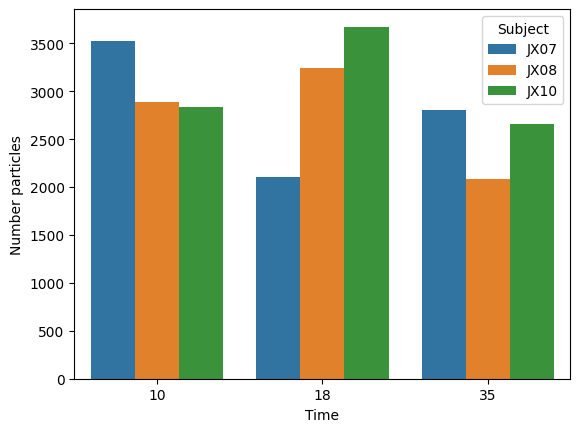

In [29]:
fig, ax = plt.subplots()
ax=sns.barplot(data=particle_stats, x='Time', y='Number particles', hue='Subject', ax=ax)
ax.legend(bbox_to_anchor=(1,1), title='Subject')

### visualize/inspect distribution of reads per particle

In [30]:
read_stats = dataset.get_read_stats()

In [31]:
read_stats.head()

,Time,Subject,Particle,Number reads
0,10,JX07,0,344.0
1,10,JX07,1,413.0
2,10,JX07,2,8134.0
3,10,JX07,3,4943.0
4,10,JX07,4,961.0


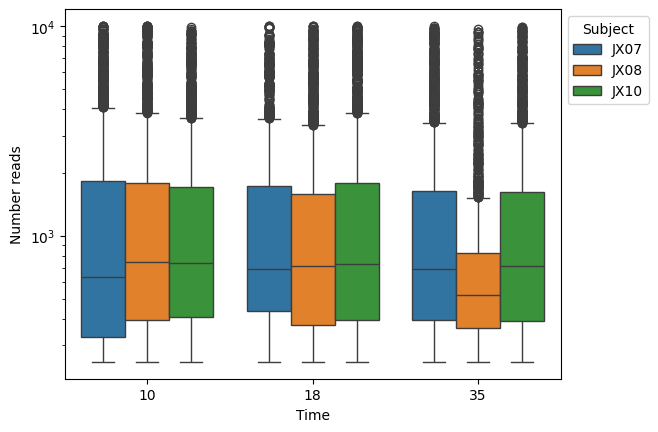

In [32]:
fig, ax = plt.subplots()
ax=sns.boxplot(data=read_stats, x='Time', y='Number reads', hue='Subject', ax=ax)
ax.legend(bbox_to_anchor=(1,1), title='Subject')
ax.set_yscale('log')

### visualize/inspect (aggregated) relative abundances in each sample

In [33]:
relative_abundance = dataset.get_relative_abundances()

In [34]:
print(relative_abundance.keys())

dict_keys(['JX07', 'JX08', 'JX10'])


In [35]:
relative_abundance['JX07'].head()

10  \
Domain   Phylum        Class       Order         Family          Genus                     
Bacteria Firmicutes    Clostridia  Clostridiales Lachnospiraceae Enterocloster  0.012639   
                                                                 Anaerotignum   0.000000   
                                                                 na             0.000006   
                                                                 na             0.001872   
         Bacteroidetes Bacteroidia Bacteroidales na              na             0.111646   

                                                                                      18  \
Domain   Phylum        Class       Order         Family          Genus                     
Bacteria Firmicutes    Clostridia  Clostridiales Lachnospiraceae Enterocloster  0.002710   
                                                                 Anaerotignum   0.009596   
                                                                 na             0.011367   
                                                                 na             0.042867   
         Bacteroidetes Bacteroidia Bacteroidales na              na             0.012523   

                                                                                      35  
Domain   Phylum        Class       Order         Family          Genus                    
Bacteria Firmicutes    Clostridia  Clostridiales Lachnospiraceae Enterocloster  0.006679  
                                                                 Anaerotignum   0.000960  
                                                                 na             0.001159  
                                                                 na             0.000008  
         Bacteroidetes Bacteroidia Bacteroidales na              na             0.003027

In [39]:
def filter_taxa(relabund_df, threshold):
    CUTOFF_FRAC_ABUNDANCE = threshold
    # Only keep taxa that have relabund mean exceeding threshold.
    to_keep = relabund_df.loc[relabund_df.mean(axis=1) > CUTOFF_FRAC_ABUNDANCE]
    to_remove = relabund_df.loc[relabund_df.mean(axis=1) <= CUTOFF_FRAC_ABUNDANCE]
    to_keep = to_keep.assign(
        Avg=np.mean(to_keep.values, axis=1)
    ).sort_values('Avg', ascending=False).drop(columns=['Avg'])
    return to_keep.index, to_remove.index

In [42]:
ra = relative_abundance['JX07'].copy()
ra_grouped =  ra.groupby(level=['Order','Family']).sum()
# to_keep, to_remove = filter_taxa(ra, 0.01)

In [43]:
ra_grouped

10        18            35
Order              Family                                                 
Bacillales         Bacillaceae_1          0.001142  0.002378  5.030341e-03
Bacteroidales      Muribaculaceae         0.088512  0.015157  1.012047e-02
                   Porphyromonadaceae     0.026025  0.000013  7.081131e-03
                   na                     0.118467  0.037984  4.505062e-03
Clostridiales      Eubacteriaceae         0.002347  0.033153  2.134720e-02
                   Lachnospiraceae        0.101746  0.426908  3.622239e-01
                   Peptostreptococcaceae  0.000000  0.061898  4.251196e-08
                   Ruminococcaceae        0.090502  0.038244  5.117930e-02
                   na                     0.070192  0.042833  1.189928e-03
Eggerthellales     Eggerthellaceae        0.015412  0.042942  3.789166e-02
Erysipelotrichales Erysipelotrichaceae    0.100761  0.074604  9.958737e-02
Lactobacillales    Lactobacillaceae       0.369346  0.124735  3.328105e-01
Verrucomicrobiales Akkermansiaceae        0.015548  0.099152  6.703313e-02

In [45]:
to_keep, to_remove = filter_taxa(ra_grouped, 0.01)

In [49]:

def plot_relative_abundances(relabund_df, to_keep, to_remove, ax, cmap='tab20', threshold=0.01):
    """
    Plot the relative abundances as a stacked bar chart.
    """
#     def _filter_taxa(relabund_df, threshold):
#         CUTOFF_FRAC_ABUNDANCE = threshold
#         # Only keep taxa that have relabund mean exceeding threshold.
#         to_keep = relabund_df.loc[relabund_df.mean(axis=1) > CUTOFF_FRAC_ABUNDANCE]
#         to_remove = relabund_df.loc[relabund_df.mean(axis=1) <= CUTOFF_FRAC_ABUNDANCE]
#         to_keep = to_keep.assign(
#             Avg=np.mean(to_keep.values, axis=1)
#         ).sort_values('Avg', ascending=False).drop(columns=['Avg'])
#         return to_keep.index, to_remove.index

#     to_keep, to_remove = _filter_taxa(relabund_df, threshold)

    # Only plot the OTUs that have mean relabund exceeding threshold.
    to_keep = relabund_df.loc[to_keep]
    to_remove = relabund_df.loc[to_remove]
    
    relabund_df = to_keep.assign(
        Avg=np.mean(to_keep.values, axis=1)
    ).sort_values('Avg', ascending=False).drop(columns=['Avg'])
    relabund_df.loc[('Other', 'Other'), :] = to_remove.sum().values

    # Do the plotting.
    relabund_df.T.plot.area(stacked=True, ax=ax, cmap=cmap)
    
    num_t = relabund_df.shape[1]
    num_r = relabund_df.shape[0]

    times = np.asarray(list(relabund_df.columns))
    xlocs = np.arange(0, len(times), step = 10)
    ax.set_xticks(xlocs)
    ax.set_xticklabels(times[xlocs])
    ax.set_ylim([0, 1])
    ax.set_xlim([0, num_t - 1])
    # handles, labels = ax.get_legend_handles_labels()
    return ax #, handles, labels

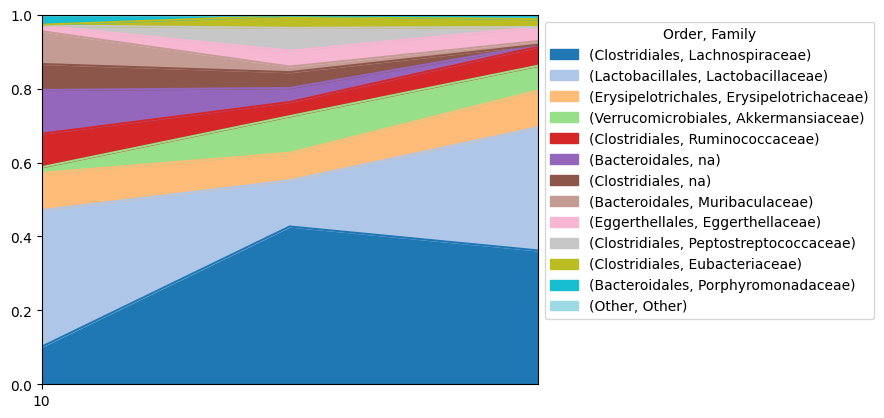

In [52]:
fig, ax = plt.subplots()
ax = plot_relative_abundances(ra_grouped, to_keep, to_remove, ax)
ax.legend(bbox_to_anchor=(1,1), title='Order, Family')